## **Χρήστος-Αλέξανδρος Δαρδαμπούνης ΑΕΜ:10335 (Τμήμα Ηλεκτρολόγων Μηχανικών & Μηχανικών Υπολογιστών)**

# Αναφορά σχετικά με την 2 $^{Η}$ Υποχρεωτική Εργασία

Το παρόν notebook περιλαμβάνει την αναφορά σχετική με την δεύτερη υποχρεωτική εργασία όπου φτίαχνω ένα **SVM**(Support Vector Machine) για να την κατηγοροιοποίηση των εικόνων της CIFAR-10 και συγκρίνω την απόδοση του με την απόδοση που είχαν οι αλγόριθμοι πλησιέστερου γείτονα και πλησιέστερου κέντρου καθώς επίσης και με το νευρωνικό δίκτυο της πρώτης εργασίας.

Στην παρούσα εργασία σχεδιάστηκαν και δοκιμάστηκαν αρκετά και διαφορετικά μοντέλα προκειμένου να μπορέσω να κατορθώσω να πετύχω ένα καλό ποσοστό ακρίβειας για την συγκεκριμένη βάση δεδομένων. Είναι γνωστό πως η CIFAR-10 είναι μια απαιτητική βάση με εικόνες οπότε αναμένουμε το **SVM** πάνω στα raw data να μην αποδόσει σε ικανοποιητικό βαθμό.

Σκοπός του SVM είναι η επίλυση του ακόλουθου προβλήματος βελτιστοποίησης : 
$$
\min_{w, b, \xi} \quad \frac{1}{2} \|w\|^2 + C \sum_{i=1}^n \xi_i
$$
subject to:

$$
y_i \left( w^\top x_i + b \right) \geq 1 - \xi_i, \quad \xi_i \geq 0, \quad \forall i = 1, \dots, n
$$
Το οποίο γίνεται στο δυικό του ως εξής : 
$$
\max_{\alpha} \quad \sum_{i=1}^n \alpha_i - \frac{1}{2} \sum_{i=1}^n \sum_{j=1}^n \alpha_i \alpha_j y_i y_j k(x_i, x_j)
$$

subject to:

$$
\sum_{i=1}^n \alpha_i y_i = 0, \quad 0 \leq \alpha_i \leq C, \quad \forall i = 1, \dots, n
$$

Με σκοπό την εύρεση μιας υπερεπιφάνειας με το μέγιστο περιθώριο(το οποίο ρυθμίζεται για το πόσο αυστηρό θα είναι μέσω της παραμέτρου C) για τον διαχωρισμό των κλάσεων

## Εισαγωγή των απαραίτητων βιβλιοθηκών και φόρτωση της βάσης δεδομένων

Αρχικά, κάνω import όλα τα απαραίτητα libraries τα οποία θα χρειαστούν για την σύγκριση των δύο αλγορίθμων οπώς επίσης φορτώνω και την βάση δεδομένων μου σύμφωνα με τις οδηγίες που αναφέρονται στο παρακάτω link : https://www.cs.toronto.edu/~kriz/cifar.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import pickle
import time
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import BaggingClassifier

Οι παραπάνω βιβλιοθήκες είναι χρήσιμες για τους εξής λόγους :
* Η **numpy** για πράξεις μεταξύ πινάκων και διανυσμάτων, για αποφυγή for loops και για κατάλληλο χειρισμό των εικόνων.
* Η **matplolib** για την οπτικοποίηση των αποτελεσμάτων μας. 
* Η **opencv(cv2)** για τον διαχειρισμό των εικόνων της CIFAR-10.
* Η **PyTorch(torch)** για την δημιουργία του νευρωνικού δικτύου και για την εκπαίδευση τους στην κάρτα γραφικών **(GPU)** για μεγαλύτερες ταχύτητες εκτέλεσης.
* Η **os** και η **pickle** για την φόρτωση των αρχείων της CIFAR-10.
* Επίσης από την **sklearn** κάνω import την κλάση `StandardScaler()` και την κλάση `PCA()` για να μειώσω τις διαστάσεις του προβλήματος μου και να βοηθήσω τους αλγόριθμους.
* Εισάγω επίσης από την **sklearn.svm** την `SVC()` για να πραγματοποιήσω το **SVM**.
* Εισάγω, ακόμα την `GridSearchCV()` και την `RandomizedSearchCV()` για να μπορέσω να πραγματοποιήσω την τεχνική του *Cross-Validation*.
* Eπιπλέον για την αξιολόγη του μοντέλου μου εισάγω από την `sklearn.metrics()` το `accuracy_score()`, `balanced_accuracy_score()`, `classification_report()` και το `confusion_matrix()`.
* Επίσης εισάγω και τον `BaggingClassifier()` για να πραγματοποιήσω την μέθοδο `Bootstrap` ή και το `Feature Bagging` και να αξιολογήσω την απόδοση.
* Επιπλέον, εισάγω από την **skimage** την συνάρτηση `hog()` ο οποίος είναι ένας feature descriptor αλγόριθμος που μετράει τις εμφανίσεις των προσανατολισμών των gradient σε τοπικές μερίδες της εικόνας, δίνοντας έτσι χρήσιμα χαρακτηριστικά τα οποία μπορούν να χρησιμοποιηθούν αντί για ολόκληρο το set των features και άρα μπορεί να βοηθήσει στην κατηγοριοποίση των εικόνων ενώ επίσης μπορεί να επιταγχύνει σημαντικά την διαδικασία εκπαίδευσης.
* Επιπρόσθετα, από την `torch` εισάγω το module `nn` το οποίο παρέχει απαραίτητες συναρτήσεις που θα με βοηθήσουν να στήσω το νευρωνικό (είτε **MLP** είτε **CNN**).

## Φόρτωση της CIFAR-10 

Στο παρακάτω κομμάτι κώδικα φορτώνω όλα τα αρχεία της βάσης και τα χωρίζω σε training και testing, όπως επίσης χωρίζω και τα labels.

In [2]:
directory = r'C:\Users\chris\OneDrive\Υπολογιστής\9ο ΕΞΑΜΗΝΟ\ΝΕΥΡΩΝΙΚΑ ΔΙΚΤΥΑ & ΒΑΘΙΑ ΜΑΘΗΣΗ\cifar-10-python\cifar-10-batches-py'
data = {}
for file in os.listdir(directory):
    with open(directory + "\\" + file, 'rb') as f:
        data[f'{file}'] =  pickle.load(f, encoding='bytes')

filename = r'C:\Users\chris\OneDrive\Υπολογιστής\9ο ΕΞΑΜΗΝΟ\ΝΕΥΡΩΝΙΚΑ ΔΙΚΤΥΑ & ΒΑΘΙΑ ΜΑΘΗΣΗ\cifar-10-python\cifar-10-batches-py\test_batch'
with open(filename, 'rb') as fo:
    test_data = pickle.load(fo, encoding='bytes')


X_train = np.vstack((data['data_batch_1'][b'data'], data['data_batch_2'][b'data'], data['data_batch_3'][b'data'], data['data_batch_4'][b'data'], data['data_batch_5'][b'data']), dtype=np.uint8)
y_train = np.hstack((data['data_batch_1'][b'labels'], data['data_batch_2'][b'labels'], data['data_batch_3'][b'labels'], data['data_batch_4'][b'labels'], data['data_batch_5'][b'labels']), dtype=np.int32)
X_test = test_data[b'data']
y_test = np.array(test_data[b'labels'])
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((50000, 3072), (50000,), (10000, 3072), (10000,))

In [3]:
filename = r'C:\Users\chris\OneDrive\Υπολογιστής\9ο ΕΞΑΜΗΝΟ\ΝΕΥΡΩΝΙΚΑ ΔΙΚΤΥΑ & ΒΑΘΙΑ ΜΑΘΗΣΗ\cifar-10-python\batches.meta'
with open(filename, 'rb') as fo:
    example = pickle.load(fo, encoding='bytes')

label_names = [label_name.decode('utf-8') for label_name in example[b'label_names']] 
label_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

## Image Visualization

Στην συνέχεια για να βεβαιωθώ όταν φορτώθηκαν σωστά τα αρχεία από την CIFAR-10 σχηματίζω τις εικόνες και κάνω plot ενδεικτικά μια από αυτές.

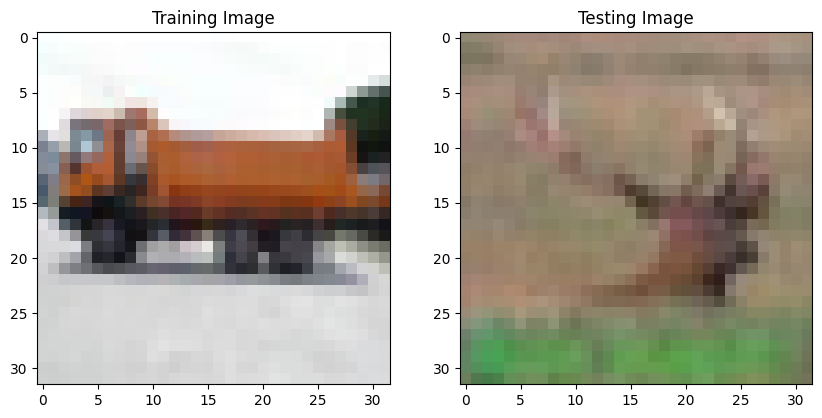

In [4]:
X = np.vstack((X_train, X_test))
y = np.hstack((y_train, y_test))
img = np.zeros(shape=(32, 32, 3), dtype=np.uint8)
images = np.zeros(shape=(X.shape[0], 32, 32, 3), dtype=np.uint8)
train_images = np.zeros(shape=(X_train.shape[0], 32, 32, 3), dtype=np.uint8)
test_images = np.zeros(shape=(X_test.shape[0], 32, 32, 3), dtype=np.uint8)

for i in range(X.shape[0]):
    red_channel   = X[i, 0:1024].reshape(32, 32)
    green_channel = X[i, 1024:2048].reshape(32, 32)
    blue_channel  = X[i, 2048:3072].reshape(32, 32)

    img = np.dstack((red_channel, green_channel, blue_channel))

    images[i] = img

for i in range(X_train.shape[0]):
    red_channel   = X_train[i, 0:1024].reshape(32, 32)
    green_channel = X_train[i, 1024:2048].reshape(32, 32)
    blue_channel  = X_train[i, 2048:3072].reshape(32, 32)

    img = np.dstack((red_channel, green_channel, blue_channel))

    train_images[i] = img

for i in range(0, X_test.shape[0]):
    red_channel   = X_test[i, 0:1024].reshape(32, 32)
    green_channel = X_test[i, 1024:2048].reshape(32, 32)
    blue_channel  = X_test[i, 2048:3072].reshape(32, 32)

    img = np.dstack((red_channel, green_channel, blue_channel))
    test_images[i] = img

fig, ax = plt.subplots(1, 2, figsize=(10, 8))
ax[0].imshow(train_images[28635])
ax[0].set_title('Training Image')
ax[1].imshow(test_images[2183])
ax[1].set_title('Testing Image')
plt.show()

## ΗΟG Features combined with PCA

Στην ενδιάμεση εργασία είχα καταλήξει στο γεγονός πως τα features που εξήγαγα από την κάθε εικόνα μου έδιναν τα καλύτερα αποτέλεσμα και για τον αλγόριθμο πλησιέστερου γείτονα αλλά και για τον αλγόριθμου πλησιέστερου κέντρου, οπότε για αυτό τον λόγο θεωρώ λογικό να φτιάξω αρχικά ένα νευρωνικό προσαρμοσμένο σε αυτά καθότι αναμένω πως και αυτό θα μου δώσει αρκετά καλά αποτελέσματα. Οπότε, όπως και προηγουμένως κάνω εξαγωγή αυτών των features και στην συνέχεια δημιουργώ την κλάση για το νευρωνικό. 

In [4]:
def compute_hog_features(image):
    hog_features, hog_image = hog(image, pixels_per_cell=(8, 8),
                                  cells_per_block=(2, 2), visualize=True, channel_axis=-1, transform_sqrt=True)
    return hog_features

X_train_HOG = np.zeros(shape=(train_images.shape[0], 324))
X_test_HOG  = np.zeros(shape=(test_images.shape[0], 324))

for i in range(train_images.shape[0]):
    X_train_HOG[i, :] = compute_hog_features(train_images[i])

for i in range(test_images.shape[0]):
    X_test_HOG[i, :] = compute_hog_features(test_images[i])

X_train_HOG.shape, X_test_HOG.shape

((50000, 324), (10000, 324))

Παρακάτω δημιουργώ μια συνάρτηση η οποία θα μου πραγματοποιεί αξιολόγηση του μοντέλου που έχω φτιάξει λαμβάνοντας υπόψη όλες τις μετρικές που έχω αναφέρει προηγουμένως καθώς επίσης και το classification report που περιλαμβάνει και άλλες μετρικές όπως είναι το recall(που μας δείχνει πόσα από τα δείγματα βρήκε), precision(που μας δείχνει πόσα από τα δείγματα που βρήκε σε μια συγκεκριμένη κλάση, ανήκουν όντως σε εκείνη την κλάση) και τέλος το f1-score.

In [5]:
def evaluate_model(y_test, y_pred):
    report = {}

    report["accuracy"] = accuracy_score(y_test, y_pred)*100
    report["balanced_accuracy"] = balanced_accuracy_score(y_test, y_pred)*100
    report["classification"] = classification_report(y_test, y_pred, output_dict=True)
    report["conf_matrix"] = confusion_matrix(y_test, y_pred)

    return report

Λόγω του πολύ μεγάλου όγκου των δεδομένων που έχει η **CIFAR-10** εφαρμόζω πρώτα **PCA** για να μειώσω το πλήθος το features κρατώντας το 90% της πληροφορίας της κάθε εικόνας και άρα να μπορεί να τρέξει πιο γρήγορα ο αλγόριθμος κατηγοριοποίησης των κλάσεων με την χρήση **SVM**, ωστόσο θα πρέπει να αναμένουμε μικρότερη ακρίβεια εξαιτίας της εφαρμογής του **PCA**.

In [6]:
pca = PCA(n_components=0.9)
sc = StandardScaler()

X_train_scaled = sc.fit_transform(X_train)
X_test_scaled  = sc.transform(X_test)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca  = pca.transform(X_test_scaled)

X_train_pca.shape, X_test_pca.shape

((50000, 103), (10000, 103))

Πριν δοκιμάσω το **SVM** στα raw data, μετά την εφαρμογή PCA, που παίρνω από την CIFAR-10, το δοκιμάζω στα Hog Features που έχω βρει καθότι μου φαίνεται πως θα αποδίδουν καλύτερα όπως συνέβη και με το κλασσικό **MLP** αλλά και με τους αλγορίθμους πλησιέστερου γείτονα και πλησιέστερου κέντρου. Αρχικά δοκιμάζω με RBF kernel : 
$$
k(x, x') = \exp\left(-\frac{\|x - x'\|^2}{2\sigma^2}\right)
$$

Όπου 
$$
\gamma = \frac{1}{2\sigma^2}
$$

In [7]:
svm_hog_1 = SVC(C=10, kernel="rbf", gamma=0.01, random_state=42)
svm_hog_1.fit(X_train_HOG, y_train)

y_preds = svm_hog_1.predict(X_test_HOG)
report_hog = evaluate_model(y_test, y_preds)

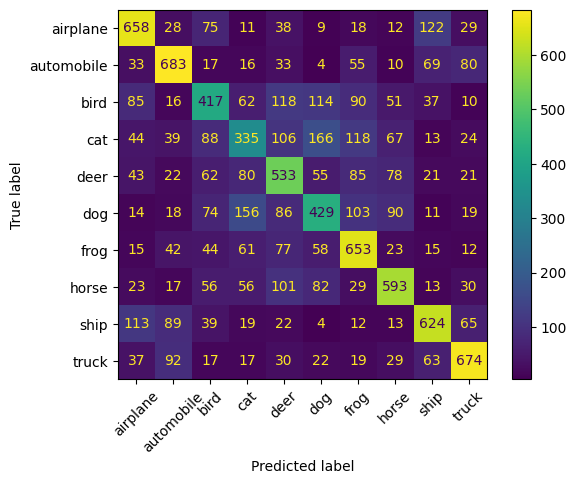

,precision,recall,f1-score,support
0,0.617840,0.6580,0.637288,1000.0000
1,0.652964,0.6830,0.667644,1000.0000
2,0.469066,0.4170,0.441503,1000.0000
3,0.412054,0.3350,0.369553,1000.0000
4,0.465909,0.5330,0.497201,1000.0000
5,0.454931,0.4290,0.441585,1000.0000
6,0.552453,0.6530,0.598533,1000.0000
7,0.613872,0.5930,0.603255,1000.0000
8,0.631579,0.6240,0.627767,1000.0000
9,0.699170,0.6740,0.686354,1000.0000


In [10]:
class_report = report_hog["classification"]
conf_mat = report_hog["conf_matrix"]
disp = ConfusionMatrixDisplay(conf_mat, display_labels=label_names)
disp.plot()
plt.xticks(rotation=45)  
plt.show()
df_classification_report = pd.DataFrame(class_report).transpose()
df_classification_report

Από τα αποτελέσματα μας παρατηρούμε πως τα Hog Features αποδίδουν πολύ καλά όπως και αναμέναμε και βλέπουμε πως με την χρήση RBF πυρήνα πετυχαίνουμε πολύ καλή ακρίβεια που φτάνει το 56%. Αυτό προφανώς είναι αρκετά καλό γιατί σημαίνει πως τα HOG Features διαχωρίζονται με μεγάλη επιτυχία. Ωστόσο, αποδίδει χειρότερα από ότι απέδιδε με το κλασσικό **MLP** που χρησιμοποίησα στην προηγούμενη εργασία, ενώ επίσης αποδίδει ελαφρώς καλύτερα από τον αλγόριθμο πλησιέστερου γείτονα της ενδιάμεσης εργασίας.

Ας δοκιμάσουμε τώρα να αλλάξουμε τις παραμέτρους για να δούμε τα αποτέλεσματα που θα πάρουμε. Αρχικά δοκιμάζω να αλλάξω την υπερπαράμετρο C και συγκεκριμένα την μειώνω, επιτρέποντας με αυτό τον τρόπο να γίνονται περισσότερα λάθη και άρα βάζοντας εν τέλει μικρότερη ποινή στα δεδομένα οπότε θα αναμένω να έχω περισσότερα support vectors και άρα να έχω μικρότερη ακρίβεια από ότι προηγουμένως.

In [11]:
svm_hog_2 = SVC(C=1, kernel="rbf", gamma=0.01, random_state=42)
svm_hog_2.fit(X_train_HOG, y_train)
y_preds = svm_hog_2.predict(X_test_HOG)
report_hog2 = evaluate_model(y_test, y_preds)

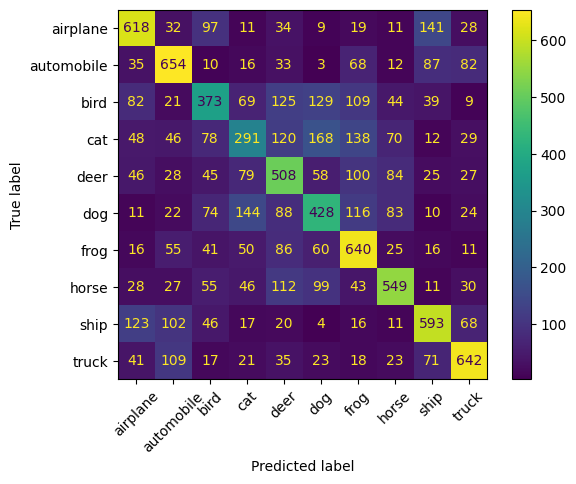

,precision,recall,f1-score,support
0,0.589695,0.6180,0.603516,1000.0000
1,0.596715,0.6540,0.624046,1000.0000
2,0.446172,0.3730,0.406318,1000.0000
3,0.391129,0.2910,0.333716,1000.0000
4,0.437554,0.5080,0.470153,1000.0000
5,0.436290,0.4280,0.432105,1000.0000
6,0.505130,0.6400,0.564623,1000.0000
7,0.601974,0.5490,0.574268,1000.0000
8,0.590050,0.5930,0.591521,1000.0000
9,0.675789,0.6420,0.658462,1000.0000


In [12]:
class_report = report_hog2["classification"]
conf_mat = report_hog2["conf_matrix"]
disp = ConfusionMatrixDisplay(conf_mat, display_labels=label_names)
disp.plot()
plt.xticks(rotation=45) 
plt.show()
df_classification_report = pd.DataFrame(class_report).transpose()
df_classification_report

Από τα παραπάνω αποτελέσματα βλέπουμε πως η ακρίβεια όντως μειώθηκε όπως και περιμέναμε και αυτό διότι επιτρέψαμε περισσότερα samples να μπορούν να γίνουν support vectors. Ωστόσο, το ποσοστό της ακρίβειας κατά το οποίο έπεσε δεν είναι αρκετά μεγάλο, άρα αυτό μας οδηγεί στο να αλλάξουμε κάποια άλλη υπερπαράμετρο για να δούμε άμα θα κατορθώσουμε να αυξήσουμε την ακρίβεια ή να την μειώσουμε. Ας δοκιμάσουμε τώρα να αυξήσουμε την διασπορά του RBF πυρήνα (δηλαδή να μειώσουμε περαιτέρω την παράμετρο ***γ***)

In [13]:
svm_hog_3 = SVC(C=10, kernel="rbf", gamma=0.001, random_state=42)
svm_hog_3.fit(X_train_HOG, y_train)
y_preds = svm_hog_3.predict(X_test_HOG)
report_hog3 = evaluate_model(y_test, y_preds)

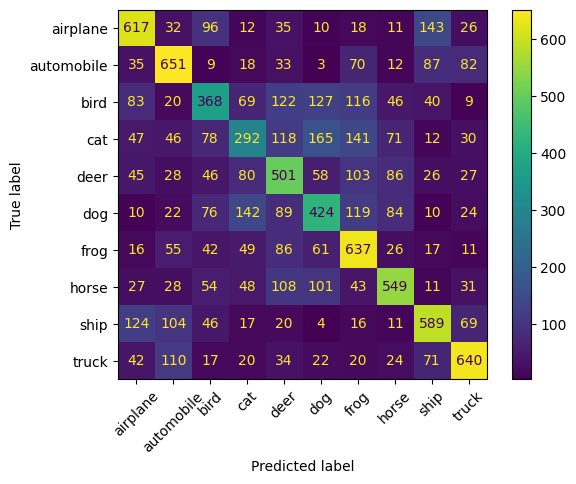

,precision,recall,f1-score,support
0,0.589866,0.6170,0.603128,1000.0000
1,0.593978,0.6510,0.621183,1000.0000
2,0.442308,0.3680,0.401747,1000.0000
3,0.390897,0.2920,0.334287,1000.0000
4,0.437173,0.5010,0.466915,1000.0000
5,0.434872,0.4240,0.429367,1000.0000
6,0.496493,0.6370,0.558038,1000.0000
7,0.596739,0.5490,0.571875,1000.0000
8,0.585487,0.5890,0.587238,1000.0000
9,0.674394,0.6400,0.656747,1000.0000


In [14]:
class_report = report_hog3["classification"]
conf_mat = report_hog3["conf_matrix"]
disp = ConfusionMatrixDisplay(conf_mat, display_labels=label_names)
disp.plot()
plt.xticks(rotation=45) 
plt.show()
df_classification_report = pd.DataFrame(class_report).transpose()
df_classification_report

Όπως μπορούμε να δούμε η αλλαγή της παραμέτρου ***γ*** είχε ελάχιστα μεγαλύτερη επίδραση στην ακρίβεια του μοντέλου μας με το **SVM** πάνω στα Hog Features επομένως μπορούμε να δούμε πως μειώνοντας της πετυχαίνουμε χειρότερη ακρίβεια από ότι προηγουμένως. Ας δούμε τώρα την επίδραση της παραμέτρου ***C*** όταν την αυξήσουμε και κάνουμε πιο αυστηρά τα όρια δίνοντας μεγαλύτερη ποινή στα διανύσματα που δεν είναι support vectors αλλά βρίσκονται μέσα στο περιθώριο είτε από την σωστή μεριά είτε από την λάθος διατηρώντας όπως το ***γ*** που χρησιμοποιήσαμε προηγουμένως.

In [15]:
svm_hog_4 = SVC(C=100, kernel="rbf", gamma=0.001, random_state=42)
svm_hog_4.fit(X_train_HOG, y_train)
y_preds = svm_hog_4.predict(X_test_HOG)
report_hog4 = evaluate_model(y_test, y_preds)

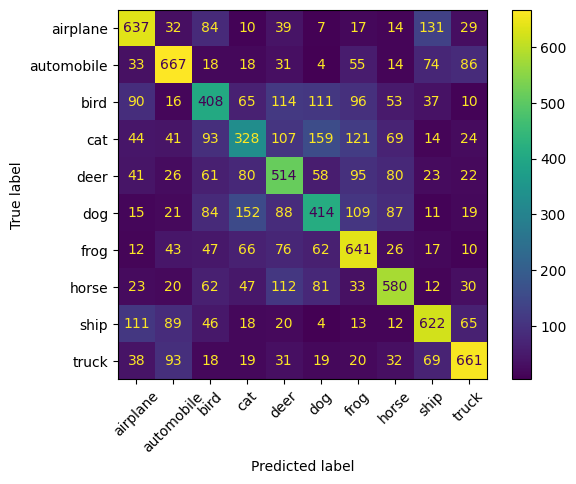

,precision,recall,f1-score,support
0,0.610153,0.6370,0.623288,1000.0000
1,0.636450,0.6670,0.651367,1000.0000
2,0.442997,0.4080,0.424779,1000.0000
3,0.408468,0.3280,0.363838,1000.0000
4,0.454064,0.5140,0.482176,1000.0000
5,0.450490,0.4140,0.431475,1000.0000
6,0.534167,0.6410,0.582727,1000.0000
7,0.599793,0.5800,0.589731,1000.0000
8,0.615842,0.6220,0.618905,1000.0000
9,0.691423,0.6610,0.675869,1000.0000


In [16]:
class_report = report_hog4["classification"]
conf_mat = report_hog4["conf_matrix"]
disp = ConfusionMatrixDisplay(conf_mat, display_labels=label_names)
disp.plot()
plt.xticks(rotation=45) 
plt.show()
df_classification_report = pd.DataFrame(class_report).transpose()
df_classification_report

Παρατηρούμε πως με αυτή την αλλαγή κατορθώσαμε να αυξήσουμε την ακρίβεια σε σχέση με προηγουμένως, επομένως μπορούμε να συμπεράνουμε πως όσο περισσότερο αυστηρό είναι το περιθώριο που ορίζουμε δηλαδή όσο πιο μεγάλη είναι η ποινή που επιβάλλουμε, τόσο περισσότερο ακριβής είμαστε στην κατηγοριοποίηση των κλάσεων με την χρήση **SVM**. Επίσης, παρατηρήσαμε πως για μικρότερη διασπορά του RBF πυρήνα(δηλαδή για μεγαλύτερο ***γ***) κατορθώσαμε επίσης να επιτύχουμε μεγαλύτερη ακρίβεια. Συνεπώς, αυτός μάλλον είναι ο συνδυασμός που πρέπει να εφαρμόσουμε για να πάρουμε ακόμα καλύτερα αποτελέσματα με Gaussian Kernel. Αυτό θα το τεστάρουμε στην συνέχεια με την χρήση του `RandomizedSearchCV()` που ανέφερα στην αρχή της εργασίας.

Στην συνέχεια, ας δοκιμάσουμε να χρησιμοποιήσουμε διαφορέτικο πυρήνα για την κατηγοριοποίηση των κλάσεων. Η αμέσως επομένη καλύτερη επιλογή θα ήταν να χρησιμοποιήσουμε πολυωνυμιακό πυρήνα. Ξεκινάμε αρχικά επιλέγοντας ενός δευτέρου βαθμού πολυώνυμο για τον διαχωρισμό των κλάσεων μας χρησιμοποιώντας το **SVM**.

$$
k(x, x') = \left(\gamma \langle x, x' \rangle + r\right)^d
$$

In [17]:
svm_hog_5 = SVC(C=1, kernel="poly", gamma=0.01, degree=2, random_state=42)
svm_hog_5.fit(X_train_HOG, y_train)
y_preds = svm_hog_5.predict(X_test_HOG)
report_hog5 = evaluate_model(y_test, y_preds)

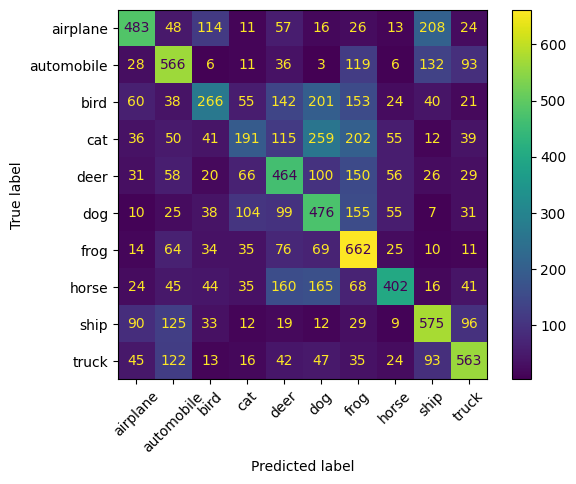

,precision,recall,f1-score,support
0,0.588307,0.4830,0.530478,1000.0000
1,0.496056,0.5660,0.528725,1000.0000
2,0.436782,0.2660,0.330640,1000.0000
3,0.356343,0.1910,0.248698,1000.0000
4,0.383471,0.4640,0.419910,1000.0000
5,0.353116,0.4760,0.405451,1000.0000
6,0.414009,0.6620,0.509427,1000.0000
7,0.600897,0.4020,0.481726,1000.0000
8,0.513852,0.5750,0.542709,1000.0000
9,0.593882,0.5630,0.578029,1000.0000


In [18]:
class_report = report_hog5["classification"]
conf_mat = report_hog5["conf_matrix"]
disp = ConfusionMatrixDisplay(conf_mat, display_labels=label_names)
disp.plot()
plt.xticks(rotation=45) 
plt.show()
df_classification_report = pd.DataFrame(class_report).transpose()
df_classification_report

Από τα παραπάνω αποτελέσματα γίνεται φανερό πως ακόμα και με αυτό τον μικρό βαθμό πολυωνύμου(2ου βαθμού) αλλά και επιβάλλοντας πολύ μικρή τιμή ποινής για τα δείγματα που βρίσκονται μέσα στο περιθώριο ή έχουν κατηγοριοποιηθεί λάθος(πιο χαλαρό περιθώριο) έχουμε πετύχει αρκετά καλά αποτελέσματα που μάλλον μας δείχνουν πως και ο πολυωνιμικός πυρήνας είναι κατάλληλος για τον διαχωρισμό των κλάσεων.

Ωστόσο, ας δοκιμάσουμε τώρα να αυξήσουμε την ποινή που επιβάλλουμε καθώς επίσης και των βαθμό του πολυωνύμου για να δούμε άμα θα έχουμε κάποια επίδραση στην συνολική ακρίβεια του μοντέλου μας.

In [19]:
svm_hog_6 = SVC(C=10, kernel="poly", gamma=0.01, degree=3, random_state=42)
svm_hog_6.fit(X_train_HOG, y_train)
y_preds = svm_hog_6.predict(X_test_HOG)
report_hog6 = evaluate_model(y_test, y_preds)

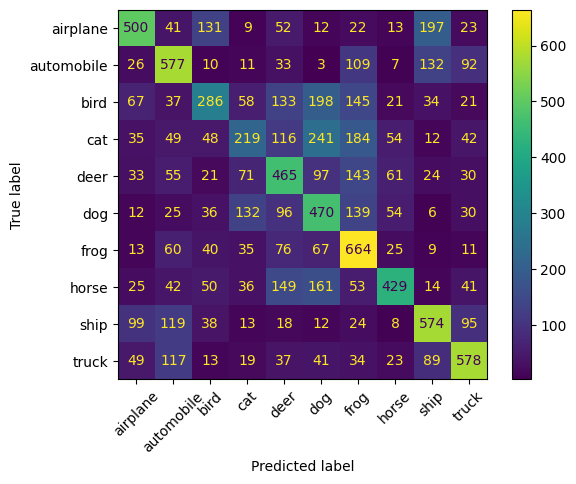

,precision,recall,f1-score,support
0,0.582072,0.5000,0.537924,1000.0000
1,0.514260,0.5770,0.543827,1000.0000
2,0.424963,0.2860,0.341901,1000.0000
3,0.363184,0.2190,0.273238,1000.0000
4,0.395745,0.4650,0.427586,1000.0000
5,0.360983,0.4700,0.408341,1000.0000
6,0.437706,0.6640,0.527612,1000.0000
7,0.617266,0.4290,0.506195,1000.0000
8,0.526123,0.5740,0.549020,1000.0000
9,0.600208,0.5780,0.588895,1000.0000


In [20]:
class_report = report_hog6["classification"]
conf_mat = report_hog6["conf_matrix"]
disp = ConfusionMatrixDisplay(conf_mat, display_labels=label_names)
disp.plot()
plt.xticks(rotation=45) 
plt.show()
df_classification_report = pd.DataFrame(class_report).transpose()
df_classification_report

Είναι φανερό πως με αυτές τις αλλαγές κατορθώσαμε να επιτύχουμε μεγαλύτερο ποσοστό ακρίβειας. Επομένως, ας προσπαθήσουμε να ανεβάσουμε τον βαθμό του πολυωνύμου καθώς επίσης να αυξήοουμε και την ποινή που θα επιβάλλουμε στα δείγματα που θα κατηγοριοποιούνται λανθασμένα.

In [21]:
svm_hog_7 = SVC(C=1000, kernel="poly", gamma=0.01, degree=5, random_state=42)
svm_hog_7.fit(X_train_HOG, y_train)
y_preds= svm_hog_7.predict(X_test_HOG)
report_hog7 = evaluate_model(y_test, y_preds)

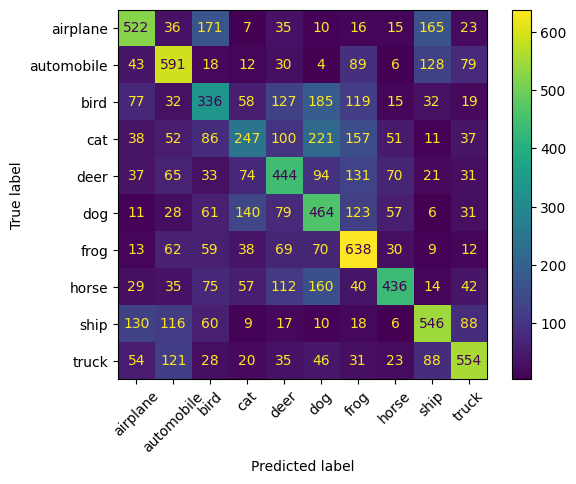

,precision,recall,f1-score,support
0,0.547170,0.5220,0.534289,1000.0000
1,0.519332,0.5910,0.552853,1000.0000
2,0.362460,0.3360,0.348729,1000.0000
3,0.373112,0.2470,0.297232,1000.0000
4,0.423664,0.4440,0.433594,1000.0000
5,0.367089,0.4640,0.409894,1000.0000
6,0.468429,0.6380,0.540220,1000.0000
7,0.614951,0.4360,0.510240,1000.0000
8,0.535294,0.5460,0.540594,1000.0000
9,0.604803,0.5540,0.578288,1000.0000


In [22]:
class_report = report_hog7["classification"]
conf_mat = report_hog7["conf_matrix"]
disp = ConfusionMatrixDisplay(conf_mat, display_labels=label_names)
disp.plot()
plt.xticks(rotation=45) 
plt.show()
df_classification_report = pd.DataFrame(class_report).transpose()
df_classification_report

Από τα παραπάνω βλέπουμε πως δεν είχαμε κάποια βελτίωση στην ακρίβεια του μοντέλου ως προς την κατηγοριοποίηση των δειγμάτων στις ορθές κλάσεις. Αυτό ίσως να οφείλεται στο γεγονός ότι αυξήσαμε σε μεγάλο βαθμό την ποινή που επιβάλλουμε στα δείγματά μας. Συνεπώς, ας "χαλαρώσουμε" λίγο αυτή την τιμή πειράζοντας ταυτόχρονα και την υπερπαράμετρο ***γ***.

In [23]:
svm_hog_8 = SVC(C=100, kernel="poly", gamma=0.001, degree=5, random_state=42)
svm_hog_8.fit(X_train_HOG, y_train)
y_preds= svm_hog_8.predict(X_test_HOG)
report_hog8 = evaluate_model(y_test, y_preds)

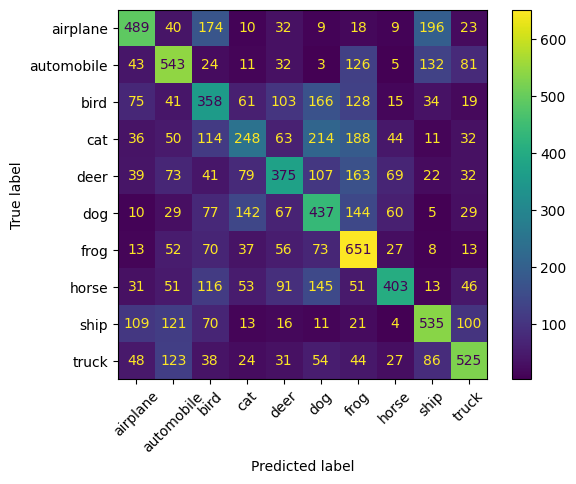

,precision,recall,f1-score,support
0,0.547592,0.4890,0.516640,1000.0000
1,0.483526,0.5430,0.511540,1000.0000
2,0.330869,0.3580,0.343900,1000.0000
3,0.365782,0.2480,0.295590,1000.0000
4,0.433025,0.3750,0.401929,1000.0000
5,0.358491,0.4370,0.393871,1000.0000
6,0.424381,0.6510,0.513812,1000.0000
7,0.607843,0.4030,0.484666,1000.0000
8,0.513436,0.5350,0.523996,1000.0000
9,0.583333,0.5250,0.552632,1000.0000


In [24]:
class_report = report_hog8["classification"]
conf_mat = report_hog8["conf_matrix"]
disp = ConfusionMatrixDisplay(conf_mat, display_labels=label_names)
disp.plot()
plt.xticks(rotation=45) 
plt.show()
df_classification_report = pd.DataFrame(class_report).transpose()
df_classification_report

Παρατηρούμε πως μειώνοντας το ***γ*** καθώς επίσης και το ***C*** είχαμε μείωση της ακρίβειας και άρα η κατηγοριοποίηση των δειγμάτων στις κατάλληλες κλάσεις δεν ήταν τόσο ορθή όπως και προηγουμένως.

Έχουμε λοιπόν πραγματοποιήσει πολλαπλές δοκιμές με την χρήση των RBF και πολυωνυμικών πυρήνων. Προς το παρόν έχουμε καταλήξει πως ο RBF πυρήνας αποδίδει καλύτερα στον διαχωρισμό των Hog Features στις κατάλληλες κλάσεις. Ωστόσο, ας πραγματοποιήσουμε ένα cross-validation για να το επιβεβαιώσουμε με σιγουριά και να δούμε ποιες είναι όντως οι καλύτερες παράμετροι καθώς επίσης και ποιος είναι ο κατάλληλος πυρήνας η χρήση του οποίου θα μας επιτρέψει να οδήγησουμε τα δεδομένα μας σε ένα χώρο μεγαλύτερης διάστασης όπου θα είναι γραμμικά διαχωρίσιμα και θα παίρνουμε καλύτερα αποτελέσματα.

In [26]:
start = time.time()
param_grid = [
    {"C": [1, 10, 100], "kernel": ["rbf"], "gamma": [1e-3, 1e-2, 1e-1, 1, "scale", "auto"]},
    {"C": [1, 10, 100], "kernel": ["poly"], "degree": [2, 3, 4, 5], "gamma": [1e-3, 1e-2, 1e-1, 1, "scale", "auto"]},
    {"C": [1, 10, 100], "kernel": ["sigmoid"], "gamma": [1e-3, 1e-2, 1e-1, 1, "scale", "auto"], "coef0": [0, 1, 10]}
]

svm = SVC(random_state=42)
random_search_hog = RandomizedSearchCV(svm, param_grid, n_iter=50, scoring="accuracy", cv=3, n_jobs=-1, verbose=2, random_state=42)
random_search_hog.fit(X_train_HOG, y_train)

end = time.time()
print(f'Elapsed Time : {end-start} seconds')

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Elapsed Time : 28376.012471199036 seconds


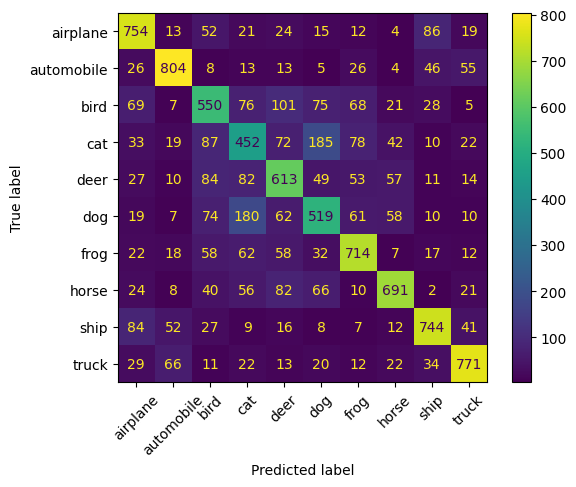

,precision,recall,f1-score,support
0,0.693652,0.7540,0.722568,1000.0000
1,0.800797,0.8040,0.802395,1000.0000
2,0.554995,0.5500,0.552486,1000.0000
3,0.464543,0.4520,0.458186,1000.0000
4,0.581594,0.6130,0.596884,1000.0000
5,0.532854,0.5190,0.525836,1000.0000
6,0.685879,0.7140,0.699657,1000.0000
7,0.752723,0.6910,0.720542,1000.0000
8,0.753036,0.7440,0.748491,1000.0000
9,0.794845,0.7710,0.782741,1000.0000


In [31]:
y_preds= random_search_hog.best_estimator_.predict(X_test_HOG)
report_hog9 = evaluate_model(y_test, y_preds)
class_report = report_hog9["classification"]
conf_mat = report_hog9["conf_matrix"]
disp = ConfusionMatrixDisplay(conf_mat, display_labels=label_names)
disp.plot()
plt.xticks(rotation=45) 
plt.show()
df_classification_report = pd.DataFrame(class_report).transpose()
df_classification_report

In [32]:
print(random_search_hog.best_params_)

{'kernel': 'rbf', 'gamma': 'scale', 'C': 10}


Από τα παραπάνω παρατηρούμε πως με τις εξής παραμέτρους επιτυγχάνουμε ένα αρκετά υψηλό ποσοστό ακρίβειας αφού κατορθώσαμε να φτάσουμε στο 66% το οποίο είναι αρκετά υψηλό σε σχέση με τα προηγούμενα που παίρναμε από τις διάφορες δοκιμές μας. Συνεπώς με την χρήση του `RandomizedSearchCV()` κατορθώσμαμε να βρούμε εκείνες τις παραμέτρους η χρήση των οποίων μας επιτρέπει να διαχωρίσουμε καλύτερα τις κλάσεις μεταξύ τους.

# RBF Kernel

Στην συνέχεια δοκιμάζω να εφαρμόσω το SVM στα δεδομένα στα οποία έχω κάνει PCA κρατώντας το 90% της αρχικής πληροφορίας των αρχικών δεδομένω της CIFAR-10. Ο λόγος που εφαρμόζω SVM στα δεδομένα μετά από PCA είναι γιατί το κάθε δείγμα της CIFAR-10 έχει υπερβολικά πολλά features με αποτέλεσμα να μην μπορέσει να πραγματοποιήσει διαχωρισμό σε ρεαλιστικό χρόνο. Ξεκινάω όπως και πριν δοκιμάζοντας πρώτα RBF kernel για να συγκρίνω τι απόδοση θα έχει.

In [7]:
svm_rbf_1 = SVC(C=10, kernel="rbf", gamma=0.01, random_state=42, verbose=True)
svm_rbf_1.fit(X_train_pca, y_train)

y_preds = svm_rbf_1.predict(X_test_pca)
report = evaluate_model(y_test, y_preds)

[LibSVM]

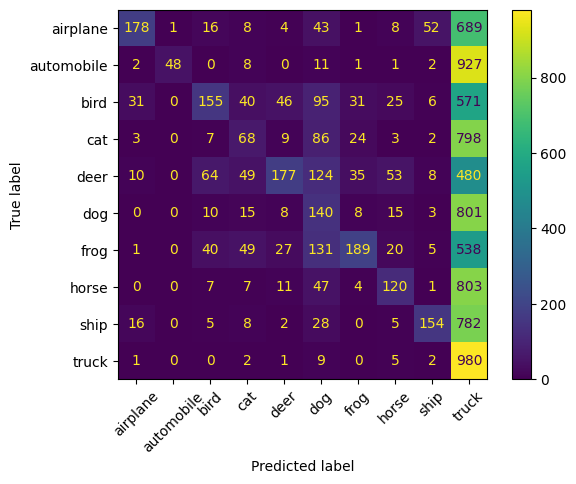

,precision,recall,f1-score,support
0,0.735537,0.1780,0.286634,1000.0000
1,0.979592,0.0480,0.091516,1000.0000
2,0.509868,0.1550,0.237730,1000.0000
3,0.267717,0.0680,0.108453,1000.0000
4,0.621053,0.1770,0.275486,1000.0000
5,0.196078,0.1400,0.163361,1000.0000
6,0.645051,0.1890,0.292343,1000.0000
7,0.470588,0.1200,0.191235,1000.0000
8,0.655319,0.1540,0.249393,1000.0000
9,0.132990,0.9800,0.234198,1000.0000


In [8]:
class_report = report["classification"]
conf_mat = report["conf_matrix"]
disp = ConfusionMatrixDisplay(conf_mat, display_labels=label_names)
disp.plot()
plt.xticks(rotation=45)  
plt.show()
df_classification_report = pd.DataFrame(class_report).transpose()
df_classification_report

Όπως βλέπουμε το SVM σε αυτή την συγκεκριμένη περίπτωση έχει πολύ κακή απόδοση αφού δεν κατόρθωσε να διαχωρίσει κατάλληλα τις κλάσεις αλλά το μόνο που έκανε ήταν να κατηγοριοποιήσει όλα τα δείγματα σε μια κλάση πράγμα που είναι τελείως λάθος. Επομένως ας προσπαθήσουμε να αλλάξουμε λίγο τις παραμέτρους προσπαθώντας να επιτύχουμε ένα καλύτερο αποτέλεσμα και να κατορθώσουμε να διαχωρίσουμε ορθά τις κλάσεις μας. Αρχικά δοκιμάζω να κάνω πιο χαλαρό το περιθώριο επιτρέποντας περισσότερα λάθη για να επαληθέψω πως θα πρέπει να είναι πιο μεγάλη η παράμετρος C και άρα πιο αυστηρό το περιθώριο για να μπορέσουμε να έχουμε σωστό classification.

In [9]:
svm_rbf_2 = SVC(C=1, kernel="rbf", gamma=0.01, random_state=42)
svm_rbf_2.fit(X_train_pca, y_train)
y_preds_2 = svm_rbf_2.predict(X_test_pca)
report_2 = evaluate_model(y_test, y_preds_2)

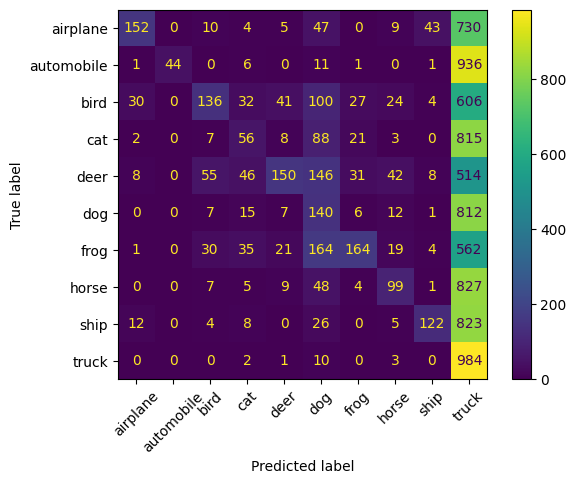

,precision,recall,f1-score,support
0,0.737864,0.1520,0.252073,1000.0000
1,1.000000,0.0440,0.084291,1000.0000
2,0.531250,0.1360,0.216561,1000.0000
3,0.267943,0.0560,0.092639,1000.0000
4,0.619835,0.1500,0.241546,1000.0000
5,0.179487,0.1400,0.157303,1000.0000
6,0.645669,0.1640,0.261563,1000.0000
7,0.458333,0.0990,0.162829,1000.0000
8,0.663043,0.1220,0.206081,1000.0000
9,0.129321,0.9840,0.228598,1000.0000


In [10]:
class_report = report_2["classification"]
conf_mat = report_2["conf_matrix"]
disp = ConfusionMatrixDisplay(conf_mat, display_labels=label_names)
disp.plot()
plt.xticks(rotation=45) 
plt.show()
df_classification_report = pd.DataFrame(class_report).transpose()
df_classification_report

Από τα παραπάνω αποτελέσματα παρατηρούμε πως έχουμε όντως μείωση της απόδοσης όπως και ήταν αναμενόμενο καθότι επιτρέψαμε να γίνονται περισσότερα λάθη κατά την διάρκεια της κατηγοριοποίησης με αποτελέσματα να έχουμε περισσότερα δείγματα σε λανθασμένες κλάσεις. Συνεπώς συμπεραίνουμε πως για καλά αποτελέσματα με αυτόν τον τύπο δεδομένων που έχουμε να κατηγοριοποιήσουμε θα πρέπει να επιβάλλουμε μεγαλύτερη ποινή στα δείγματα που ταξινομούνται λανθασμένα και άρα να είναι πιο αυστηρό το περιθώριο μας. Παρακάτω δοκιμάζουμε πέρα από την αλλαγή στην παράμετρο C να αυξήσουμε και την διασπορά του RBF kernel το οποίο αναμένουμε πως θα μας δώσει καλύτερα αποτελέσματα.

In [11]:
svm_rbf_3 = SVC(C=10, kernel="rbf", gamma=0.001, random_state=42)
svm_rbf_3.fit(X_train_pca, y_train)
y_preds_3 = svm_rbf_3.predict(X_test_pca)
report_3 = evaluate_model(y_test, y_preds_3)

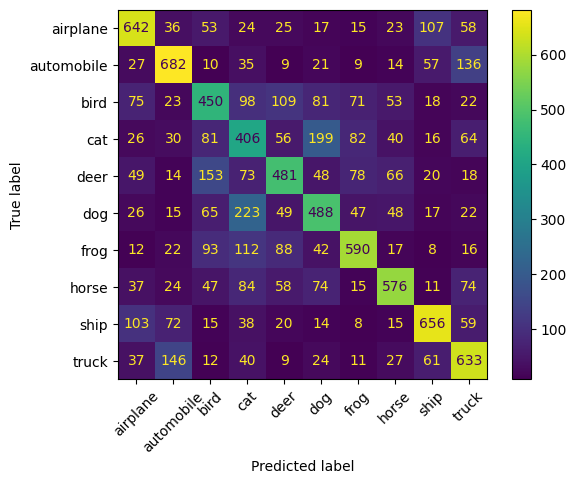

,precision,recall,f1-score,support
0,0.620890,0.6420,0.631268,1000.0000
1,0.640977,0.6820,0.660853,1000.0000
2,0.459653,0.4500,0.454775,1000.0000
3,0.358341,0.4060,0.380684,1000.0000
4,0.532080,0.4810,0.505252,1000.0000
5,0.484127,0.4880,0.486056,1000.0000
6,0.637149,0.5900,0.612669,1000.0000
7,0.655290,0.5760,0.613092,1000.0000
8,0.675592,0.6560,0.665652,1000.0000
9,0.574410,0.6330,0.602284,1000.0000


In [12]:
class_report = report_3["classification"]
conf_mat = report_3["conf_matrix"]
disp = ConfusionMatrixDisplay(conf_mat, display_labels=label_names)
disp.plot()
plt.xticks(rotation=45) 
plt.show()
df_classification_report = pd.DataFrame(class_report).transpose()
df_classification_report

Παρατηρούμε πως αυτές τις αλλαγές που προαναφέρθηκαν, κατορθώσαμε να επιτύχουμε ένα πολύ υψηλό ποσοστό ακρίβειας κατηγοριοποίησης κάτι που μας οδηγεί να πιστεύουμε στο ότι η διασπορά των δειγμάτων βοήθησε στον πιο ορθό διαχωρισμό των κλάσεων. Αυτό οφείλεται κυρίως στην μείωση του ***γ*** δηλαδή στην αύξηση της διασποράς καθότι με αυτό τον τρόπο κατορθώνουμε περισσότερη πληροφορία από την εκάστοτε κλάση και άρα γίνεται και πιο σωστά ο διαχωρισμός του πράγμα που φαίνεται από τα αποτελέσματα που λάβαμε. Ας δοκιμάσουμε στην συνέχεια να κάνουμε πιο αυστηρή την ποινή που εφαρμόζουμε.

In [13]:
svm_rbf_4 = SVC(C=100, kernel="rbf", gamma=0.001, random_state=42)
svm_rbf_4.fit(X_train_pca, y_train)
y_preds_4 = svm_rbf_4.predict(X_test_pca)
report_4 = evaluate_model(y_test, y_preds_4)

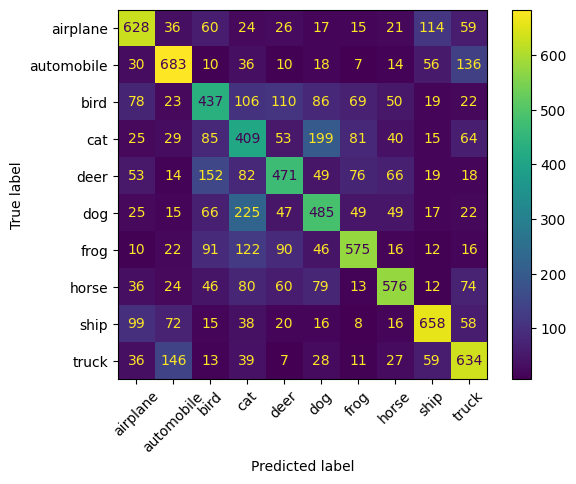

,precision,recall,f1-score,support
0,0.615686,0.6280,0.621782,1000.0000
1,0.641917,0.6830,0.661822,1000.0000
2,0.448205,0.4370,0.442532,1000.0000
3,0.352283,0.4090,0.378528,1000.0000
4,0.526846,0.4710,0.497360,1000.0000
5,0.474096,0.4850,0.479486,1000.0000
6,0.636062,0.5750,0.603992,1000.0000
7,0.658286,0.5760,0.614400,1000.0000
8,0.670744,0.6580,0.664311,1000.0000
9,0.574796,0.6340,0.602948,1000.0000


In [14]:
class_report = report_4["classification"]
conf_mat = report_4["conf_matrix"]
disp = ConfusionMatrixDisplay(conf_mat, display_labels=label_names)
disp.plot()
plt.xticks(rotation=45) 
plt.show()
df_classification_report = pd.DataFrame(class_report).transpose()
df_classification_report

Όπως βλέπουμε αυτή η αλλαγή μας έχει πολύ μικρή επίδραση και μειώνει ελάχιστα την απόδοση του κατηγοριοποιητή μας. Επομένως, αναμένουμε ότι όσο πιο αυστηρό γίνεται το όριο τόσα περισσότερα δείγματα θα κατηγοριοποιούνται λανθασμένα. Ας επαληθεύσουμε αυτή την υπόθεση μας βάζοντας ακόμα μεγαλύτερο C για να δούμε ότι ισχύει.

In [15]:
svm_rbf_5 = SVC(C=1000, kernel="rbf", gamma=0.001, random_state=42)
svm_rbf_5.fit(X_train_pca, y_train)
y_preds_5 = svm_rbf_5.predict(X_test_pca)
report_5 = evaluate_model(y_test, y_preds_5)

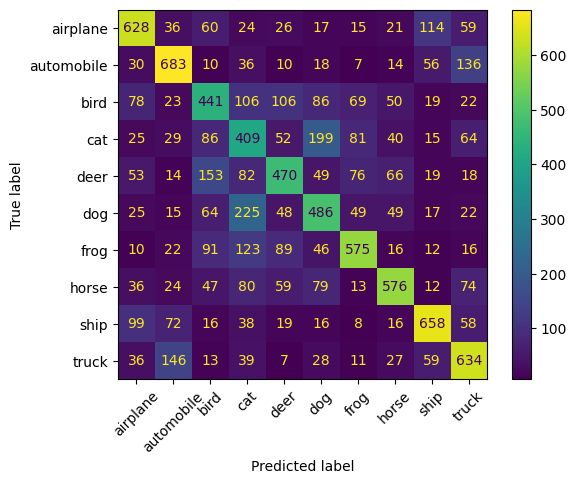

,precision,recall,f1-score,support
0,0.615686,0.628,0.621782,1000.000
1,0.641917,0.683,0.661822,1000.000
2,0.449541,0.441,0.445230,1000.000
3,0.351979,0.409,0.378353,1000.000
4,0.530474,0.470,0.498409,1000.000
5,0.474609,0.486,0.480237,1000.000
6,0.636062,0.575,0.603992,1000.000
7,0.658286,0.576,0.614400,1000.000
8,0.670744,0.658,0.664311,1000.000
9,0.574796,0.634,0.602948,1000.000


In [16]:
class_report = report_5["classification"]
conf_mat = report_5["conf_matrix"]
disp = ConfusionMatrixDisplay(conf_mat, display_labels=label_names)
disp.plot()
plt.xticks(rotation=45) 
plt.show()
df_classification_report = pd.DataFrame(class_report).transpose()
df_classification_report

Από τα παραπάνω αποτελέσματα βλέπουμε πως με αυτό τον τρόπο όντως μειώθηκε η ακρίβεια αλλά σε ελάχιστο βαθμό. Επομένως, συμπεραίνουμε πως όσο περισσότερο αυξάνουμε το C κάνοντας δηλαδή όλο και περισσότερο αυστηρή την ποινή στα λανθασμένα κατηγοριοποιημένα δείγματα τόσο περισσότερο μειώνεται η ακρίβεια κατηγοριοποίησης τους.

Ας δοκιμάσουμε τώρα τον ταξινομητή με τον πολυωνυμικό πυρήνα για να δούμε αν θα έχουμε καλύτερα αποτελέσματα όπως κάναμε και με τον HOG. Αρχικά δοκιμάζουμε ένα πολύ απλό μοντέλο με C=1, γ=0.01 και degree=2 όπου η παράμετρος degree είναι η δύναμη του πολυωνύμου.

In [17]:
svm_poly_1 = SVC(C=1, kernel="poly", gamma=0.01, degree=2, random_state=42)
svm_poly_1.fit(X_train_pca, y_train)
y_preds_poly_1 = svm_poly_1.predict(X_test_pca)
report_poly_1 = evaluate_model(y_test, y_preds_poly_1)

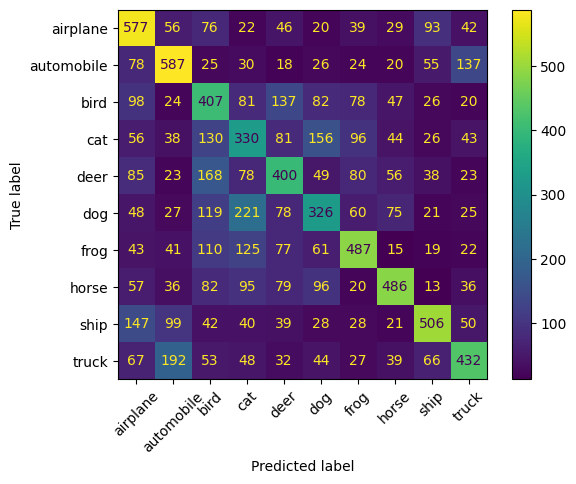

,precision,recall,f1-score,support
0,0.459395,0.5770,0.511525,1000.0000
1,0.522707,0.5870,0.552991,1000.0000
2,0.335809,0.4070,0.367993,1000.0000
3,0.308411,0.3300,0.318841,1000.0000
4,0.405268,0.4000,0.402617,1000.0000
5,0.367117,0.3260,0.345339,1000.0000
6,0.518637,0.4870,0.502321,1000.0000
7,0.584135,0.4860,0.530568,1000.0000
8,0.586327,0.5060,0.543210,1000.0000
9,0.520482,0.4320,0.472131,1000.0000


In [18]:
class_report = report_poly_1["classification"]
conf_mat = report_poly_1["conf_matrix"]
disp = ConfusionMatrixDisplay(conf_mat, display_labels=label_names)
disp.plot()
plt.xticks(rotation=45) 
plt.show()
df_classification_report = pd.DataFrame(class_report).transpose()
df_classification_report

Παρατηρούμε πως με αυτές τις αρχικές παραμέτρους πετυχαίνουμε ήδη ένα πολύ καλό αποτέλεσμα που δεν είναι όμως ωστόσο τόσο καλό όσο τα αποτελέσματα που πετυχαίναμε προηγουμένως με τον RBF πυρήνα. Συνεπώς ας προσπαθήσουμε να αυξήσουμε τον βαθμό του πολυωνύμου και ταυτόχρονα την ποινή που επιβάλλουμε στα δείγματα που κατηγοριοποιούνται λανθασμένα με την ελπίδα πως τώρα θα κατορθώσαμε να τα μετασχηματίσουμε σε ένα καινούργιο χώρο μεγαλύτερης διάστασης όπου θα είναι πιο εύκολος ο διαχωρισμός τους.

In [19]:
svm_poly_2 = SVC(C=10, kernel="poly", gamma=0.01, degree=3, random_state=42)
svm_poly_2.fit(X_train_pca, y_train)
y_preds_poly_2 = svm_poly_2.predict(X_test_pca)
report_poly_2 = evaluate_model(y_test, y_preds_poly_2)

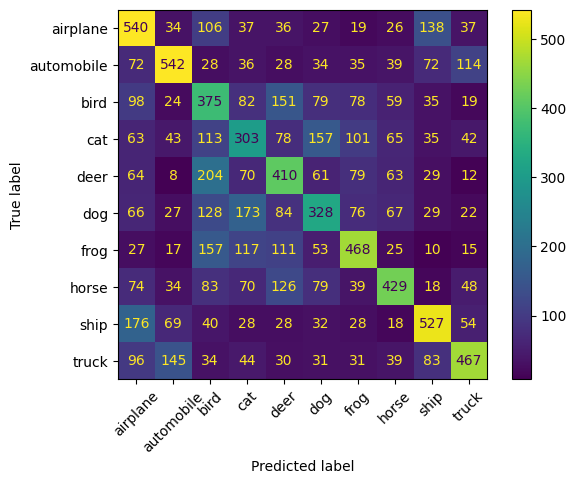

,precision,recall,f1-score,support
0,0.423197,0.5400,0.474517,1000.0000
1,0.574761,0.5420,0.557900,1000.0000
2,0.295741,0.3750,0.330688,1000.0000
3,0.315625,0.3030,0.309184,1000.0000
4,0.378928,0.4100,0.393852,1000.0000
5,0.372304,0.3280,0.348751,1000.0000
6,0.490566,0.4680,0.479017,1000.0000
7,0.516867,0.4290,0.468852,1000.0000
8,0.539959,0.5270,0.533401,1000.0000
9,0.562651,0.4670,0.510383,1000.0000


In [20]:
class_report = report_poly_2["classification"]
conf_mat = report_poly_2["conf_matrix"]
disp = ConfusionMatrixDisplay(conf_mat, display_labels=label_names)
disp.plot()
plt.xticks(rotation=45) 
plt.show()
df_classification_report = pd.DataFrame(class_report).transpose()
df_classification_report

Παρατηρούμε πως αυτή η αλλαγή μας δεν βοήθησε το αποτέλεσμα καθότι βλέπουμε πως η ακρίβεια κατηγοριοποίησης των δειγμάτων μας μειώθηκε. Ωστόσο η μείωση αυτή όπως βλέπουμε δεν είναι σημαντική. Επομένως ας δοκιμάσουμε να αυξήσουμε περαιτέρω τον βαθμό του πολυωνύμου μήπως και κατορθώσουμε κάτι διαφορετικό χρησιμοποιώντας πιο σύνθετο πυρήνα.

In [21]:
svm_poly_3 = SVC(C=10, kernel="poly", gamma=0.01, degree=4, random_state=42)
svm_poly_3.fit(X_train_pca, y_train)
y_preds_poly_3 = svm_poly_3.predict(X_test_pca)
report_poly_3 = evaluate_model(y_test, y_preds_poly_3)

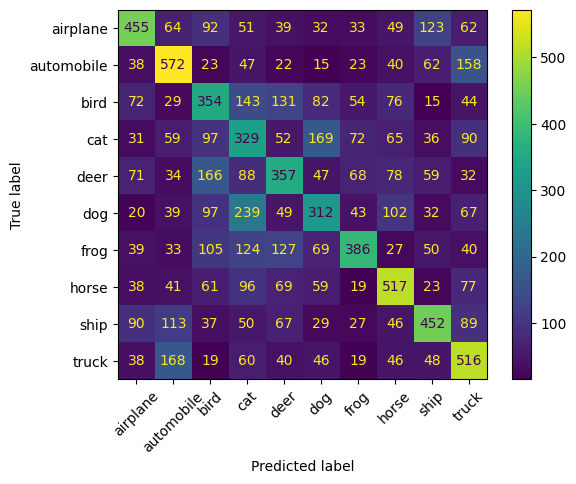

,precision,recall,f1-score,support
0,0.510090,0.455,0.480973,1000.000
1,0.496528,0.572,0.531599,1000.000
2,0.336822,0.354,0.345197,1000.000
3,0.268134,0.329,0.295465,1000.000
4,0.374607,0.357,0.365591,1000.000
5,0.362791,0.312,0.335484,1000.000
6,0.518817,0.386,0.442661,1000.000
7,0.494264,0.517,0.505376,1000.000
8,0.502222,0.452,0.475789,1000.000
9,0.439149,0.516,0.474483,1000.000


In [22]:
class_report = report_poly_3["classification"]
conf_mat = report_poly_3["conf_matrix"]
disp = ConfusionMatrixDisplay(conf_mat, display_labels=label_names)
disp.plot()
plt.xticks(rotation=45) 
plt.show()
df_classification_report = pd.DataFrame(class_report).transpose()
df_classification_report

In [23]:
svm_poly_4 = SVC(C=100, kernel="poly", gamma=0.01, degree=2, random_state=42)
svm_poly_4.fit(X_train_pca, y_train)
y_preds_poly_4 = svm_poly_4.predict(X_test_pca)
report_poly_4 = evaluate_model(y_test, y_preds_poly_4)

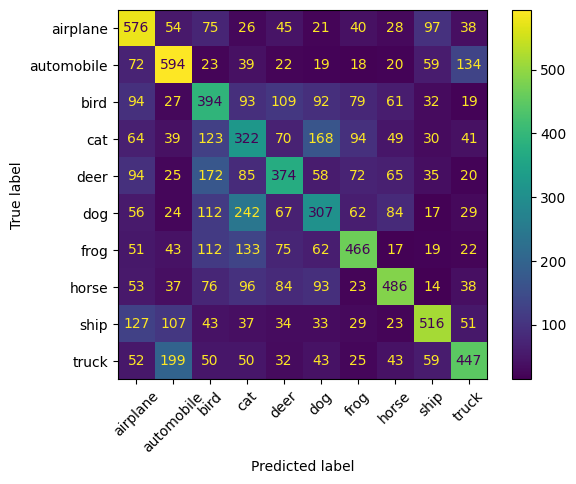

,precision,recall,f1-score,support
0,0.464891,0.5760,0.514515,1000.0000
1,0.516971,0.5940,0.552815,1000.0000
2,0.333898,0.3940,0.361468,1000.0000
3,0.286732,0.3220,0.303344,1000.0000
4,0.410088,0.3740,0.391213,1000.0000
5,0.342634,0.3070,0.323840,1000.0000
6,0.513216,0.4660,0.488470,1000.0000
7,0.554795,0.4860,0.518124,1000.0000
8,0.587699,0.5160,0.549521,1000.0000
9,0.532777,0.4470,0.486134,1000.0000


In [24]:
class_report = report_poly_4["classification"]
conf_mat = report_poly_4["conf_matrix"]
disp = ConfusionMatrixDisplay(conf_mat, display_labels=label_names)
disp.plot()
plt.xticks(rotation=45) 
plt.show()
df_classification_report = pd.DataFrame(class_report).transpose()
df_classification_report

In [25]:
svm_poly_5 = SVC(C=100, kernel="poly", gamma=0.01, degree=3, random_state=42)
svm_poly_5.fit(X_train_pca, y_train)
y_preds_poly_5 = svm_poly_5.predict(X_test_pca)
report_poly_5 = evaluate_model(y_test, y_preds_poly_5)

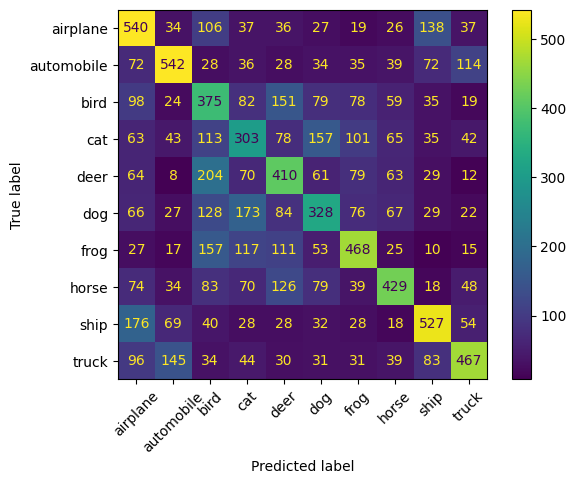

,precision,recall,f1-score,support
0,0.423197,0.5400,0.474517,1000.0000
1,0.574761,0.5420,0.557900,1000.0000
2,0.295741,0.3750,0.330688,1000.0000
3,0.315625,0.3030,0.309184,1000.0000
4,0.378928,0.4100,0.393852,1000.0000
5,0.372304,0.3280,0.348751,1000.0000
6,0.490566,0.4680,0.479017,1000.0000
7,0.516867,0.4290,0.468852,1000.0000
8,0.539959,0.5270,0.533401,1000.0000
9,0.562651,0.4670,0.510383,1000.0000


In [26]:
class_report = report_poly_5["classification"]
conf_mat = report_poly_5["conf_matrix"]
disp = ConfusionMatrixDisplay(conf_mat, display_labels=label_names)
disp.plot()
plt.xticks(rotation=45) 
plt.show()
df_classification_report = pd.DataFrame(class_report).transpose()
df_classification_report

In [27]:
svm_poly_6 = SVC(C=100, kernel="poly", gamma=0.01, degree=5, random_state=42)
svm_poly_6.fit(X_train_pca, y_train)
y_preds_poly_6 = svm_poly_6.predict(X_test_pca)
report_poly_6 = evaluate_model(y_test, y_preds_poly_6)

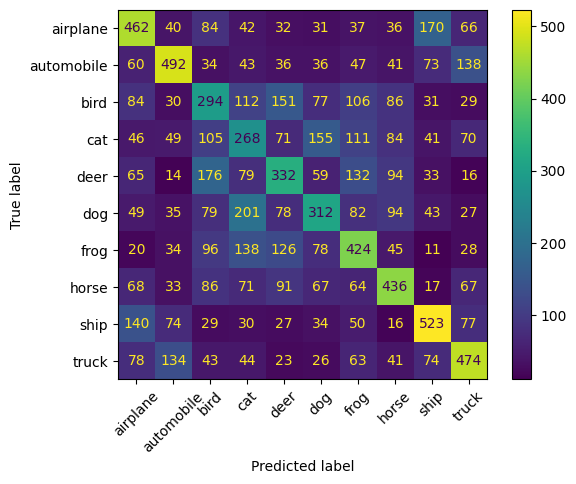

,precision,recall,f1-score,support
0,0.430970,0.4620,0.445946,1000.0000
1,0.526203,0.4920,0.508527,1000.0000
2,0.286550,0.2940,0.290227,1000.0000
3,0.260700,0.2680,0.264300,1000.0000
4,0.343330,0.3320,0.337570,1000.0000
5,0.356571,0.3120,0.332800,1000.0000
6,0.379928,0.4240,0.400756,1000.0000
7,0.448099,0.4360,0.441967,1000.0000
8,0.514764,0.5230,0.518849,1000.0000
9,0.477823,0.4740,0.475904,1000.0000


In [28]:
class_report = report_poly_6["classification"]
conf_mat = report_poly_6["conf_matrix"]
disp = ConfusionMatrixDisplay(conf_mat, display_labels=label_names)
disp.plot()
plt.xticks(rotation=45) 
plt.show()
df_classification_report = pd.DataFrame(class_report).transpose()
df_classification_report

In [29]:
svm_poly_7 = SVC(C=1000, kernel="poly", gamma=0.01, degree=5, random_state=42)
svm_poly_7.fit(X_train_pca, y_train)
y_preds_poly_7 = svm_poly_7.predict(X_test_pca)
report_poly_7 = evaluate_model(y_test, y_preds_poly_7)

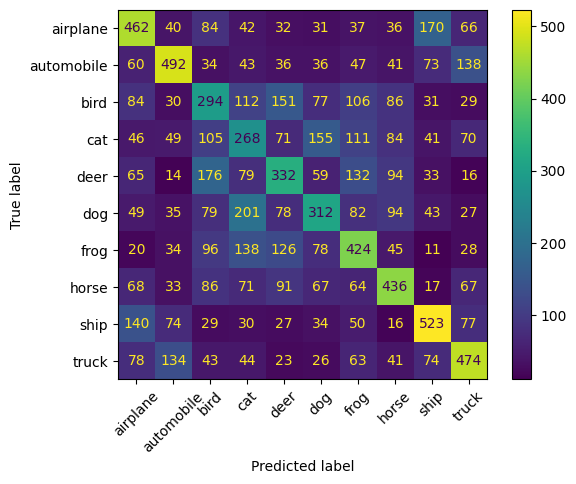

,precision,recall,f1-score,support
0,0.430970,0.4620,0.445946,1000.0000
1,0.526203,0.4920,0.508527,1000.0000
2,0.286550,0.2940,0.290227,1000.0000
3,0.260700,0.2680,0.264300,1000.0000
4,0.343330,0.3320,0.337570,1000.0000
5,0.356571,0.3120,0.332800,1000.0000
6,0.379928,0.4240,0.400756,1000.0000
7,0.448099,0.4360,0.441967,1000.0000
8,0.514764,0.5230,0.518849,1000.0000
9,0.477823,0.4740,0.475904,1000.0000


In [30]:
class_report = report_poly_7["classification"]
conf_mat = report_poly_7["conf_matrix"]
disp = ConfusionMatrixDisplay(conf_mat, display_labels=label_names)
disp.plot()
plt.xticks(rotation=45) 
plt.show()
df_classification_report = pd.DataFrame(class_report).transpose()
df_classification_report

In [12]:
base_svm = SVC(C=100, kernel="rbf", gamma=0.001, random_state=42)

bagging_clf = BaggingClassifier(estimator=base_svm, n_estimators=15, max_samples=1.0, max_features=1.0, n_jobs=-1, random_state=42, verbose=2)

bagging_clf.fit(X_train_pca, y_train)
y_preds_bag = bagging_clf.predict(X_test_pca)
report_bag = evaluate_model(y_test, y_preds_bag)

[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 out of  15 | elapsed: 15.4min remaining: 100.3min
[Parallel(n_jobs=15)]: Done  10 out of  15 | elapsed: 15.5min remaining:  7.8min
[Parallel(n_jobs=15)]: Done  15 out of  15 | elapsed: 15.6min finished
[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 out of  15 | elapsed:  2.5min remaining: 16.0min
[Parallel(n_jobs=15)]: Done  10 out of  15 | elapsed:  2.6min remaining:  1.3min
[Parallel(n_jobs=15)]: Done  15 out of  15 | elapsed:  2.6min finished


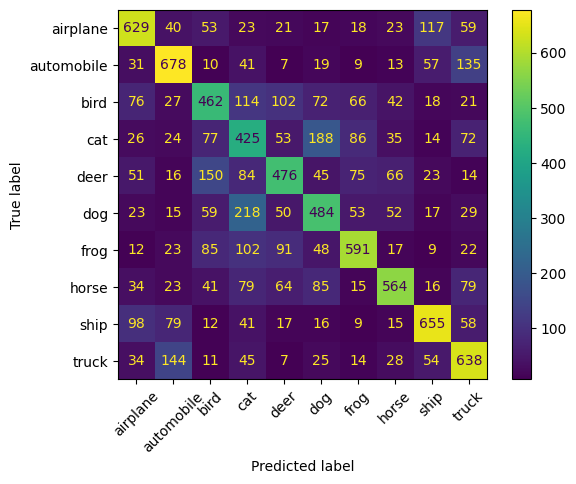

              precision    recall  f1-score   support

           0       0.62      0.63      0.62      1000
           1       0.63      0.68      0.66      1000
           2       0.48      0.46      0.47      1000
           3       0.36      0.42      0.39      1000
           4       0.54      0.48      0.50      1000
           5       0.48      0.48      0.48      1000
           6       0.63      0.59      0.61      1000
           7       0.66      0.56      0.61      1000
           8       0.67      0.66      0.66      1000
           9       0.57      0.64      0.60      1000

    accuracy                           0.56     10000
   macro avg       0.56      0.56      0.56     10000
weighted avg       0.56      0.56      0.56     10000



In [14]:
class_report = report_bag["classification"]
conf_mat = report_bag["conf_matrix"]
disp = ConfusionMatrixDisplay(conf_mat, display_labels=label_names)
disp.plot()
plt.xticks(rotation=45)
plt.show()
df_classification_report = pd.DataFrame(class_report).transpose()
df_classification_report

In [ ]:
base_svm_2 = SVC(C=10, kernel="rbf", gamma=0.001, random_state=42)

bagging_clf_2 = BaggingClassifier(estimator=base_svm_2, random_state=42, n_jobs=5)

param_grid = {
    "n_estimators": [15, 20, 25],
    "max_samples" : [0.5, 0.8, 1.0],
    "max_features": [0.5, 0.8, 1.0]
}

grid_search = RandomizedSearchCV(bagging_clf_2, param_grid, cv=3, scoring="accuracy", verbose=3, n_jobs=5, n_iter=50)
grid_search.fit(X_train_pca, y_train)

best_params = grid_search.best_params_
best_bag_clf = grid_search.best_estimator_


Fitting 3 folds for each of 27 candidates, totalling 81 fits


c:\Users\chris\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 27 is smaller than n_iter=50. Running 27 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


TypeError: 'BaggingClassifier' object is not callable

In [28]:
y_preds_bag_2 = best_bag_clf.predict(X_test_pca)
report_bag_2 = evaluate_model(y_test, y_preds_bag_2)

In [34]:
best_params

{'n_estimators': 25, 'max_samples': 1.0, 'max_features': 0.5}

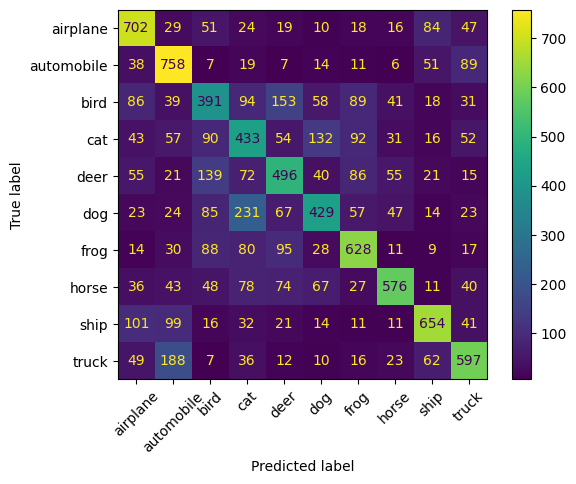

,precision,recall,f1-score,support
0,0.612031,0.7020,0.653936,1000.0000
1,0.588509,0.7580,0.662587,1000.0000
2,0.424078,0.3910,0.406868,1000.0000
3,0.393995,0.4330,0.412577,1000.0000
4,0.496994,0.4960,0.496496,1000.0000
5,0.534913,0.4290,0.476138,1000.0000
6,0.606763,0.6280,0.617199,1000.0000
7,0.705018,0.5760,0.634012,1000.0000
8,0.695745,0.6540,0.674227,1000.0000
9,0.627101,0.5970,0.611680,1000.0000


In [29]:
class_report = report_bag_2["classification"]
conf_mat = report_bag_2["conf_matrix"]
disp = ConfusionMatrixDisplay(conf_mat, display_labels=label_names)
disp.plot()
plt.xticks(rotation=45)
plt.show()
df_classification_report = pd.DataFrame(class_report).transpose()
df_classification_report

In [7]:
start = time.time()
param_grid = [
    {"C": [0.01, 0.1, 1, 10, 100, 1000], "kernel": ["rbf"], "gamma": [1e-3, 1e-2, 1e-1, 1, "scale", "auto"]},
    {"C": [0.01, 0.1, 1, 10, 100], "kernel": ["poly"], "degree": [2, 3, 4], "gamma": [1e-3, 1e-2, 1e-1, 1, "scale", "auto"]},
]

svm = SVC(random_state=42)
random_search = RandomizedSearchCV(svm, param_grid, n_iter=20, scoring="accuracy", cv=3, n_jobs=-1, verbose=2, random_state=42)
random_search.fit(X_train_pca, y_train)

end = time.time()
print(f'Elapsed Time : {end-start} seconds')

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Elapsed Time : 5198.14492225647 seconds


In [8]:
best_model = random_search.best_estimator_

y_preds = best_model.predict(X_test_pca)

In [9]:
accuracy = accuracy_score(y_test, y_preds)
accuracy

0.5604

In [10]:
random_search.best_params_

{'kernel': 'rbf', 'gamma': 0.001, 'C': 10}